# Setup

In [1]:
import numpy as np
import tensorflow as tf
from pydub import AudioSegment

import random
import sys
import io
import os
import glob
import IPython

%matplotlib inline

/home/denn1s/miniconda3/envs/tf2/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# load helper functions
sys.path.append('.')
from twd_utils import *

# Data

Build a dataset for the trigger word detection algorithm. 
- the model should detect the word "activate" in working environment (office, library, etc.) 
- create recordings with a mix of positive words ("activate") and negative words (random words other than activate) on different background sounds

Raw dataset consist of three components:
- **activates**: positive examples of people saying the word "activate"
- **negatives**: negative examples of people saying one random word other than "activate"
- **backgrounds**: contains 10 second clips of background noice in different environments

## Spectrogram
- the spectrogram tells us how much different frequencies are present in an audio clip at any moment in time: frequency + volume
- tips from advanced class on signal processing or on Fourier transforms:
    * A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform

**Overview**

In [3]:
IPython.display.Audio("./twd_audio_examples/example_train.wav")

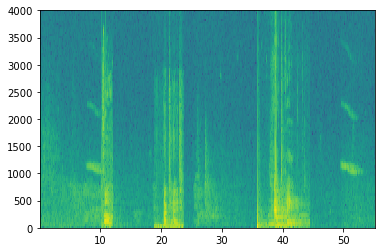

In [4]:
x = graph_spectrogram('./twd_audio_examples/example_train.wav')  # pre-loaded

In [5]:
_, data = wavfile.read('./twd_audio_examples/example_train.wav')

print("Time-steps in audio recording before spectrogram", data[:,0].shape)
print("Time-steps in input after spectrogram", x.shape)

Time-steps in audio recording before spectrogram (441000,)
Time-steps in input after spectrogram (101, 5511)


**Audio parameters**

In this notebook, we will be working with 10 second audio clips as the "standard length" for the training examples
- the number of time-steps input to the model from spectrogram: $T_x = 5511$
- the number of frequencies input to the model at each time-step of the spectrogram: $n_{freq} = 101$
- the number of time-steps in the output of the model: $T_y = 1375$

**Dividing into time-intervals**

Note that we may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
* You will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate." 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems.

In [6]:
Tx = 5511
n_freq = 101
Ty = 1375

## Data Synthesis
Because speech data is hard to acquire and label, in this notebook we will synthesize the training data using the audio clips of activates, negatives, and backgrounds:
- it is quite slow to record lots of 10 second audio clips with random "activates" in it
- instead, it is easier to record lots of positives and negative words, and record background noise separately
- by synthesis, it is easier to generate the labels $y^{\langle t \rangle}$ as well.

**Process of synthesizing audio clip**
- pick a random 10 second background audio clip
- randomly insert 0-4 audio clips of activates into this 10sec clip
- randomly insert 0-2 audio clips of negatives into this 10sec clip

**Pydub**

we will use `pydub` package to manipulate audio
- Pydub converts raw audio files into lists of Pydub data structures
- Pydub uses 1ms as the discretization interval (1ms is 1 millisecond = 1/1000 seconds)
    * a 10 second clip is always represented using 10,000 steps

In [7]:
activates, negatives, backgrounds = load_raw_audio()  # pre-loaded

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
725 

activate[1] len: different `activate` clips can have different lengths
721 



**Overlaying activtes/negatives on top of the background**
- insert multiple clips of activates/negatives into the background 
- make sure that the audio segments do not overlap when inserted: keep track of the times of previously inserted audio clips

**Label the activates/negatives**
- the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "activate" 
    * $y^{\langle t \rangle} = 1$ when that that clip has finished saying "activate"
    * given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "activates"
- when inserting or overlay an "activate" clip, you will also update labels for $y^{\langle t \rangle}$
    * rather than updating the label of a single time step, we will update 50 steps of the output to have target label 1. 
    * updating several consecutive time steps can make the training data more balanced
- in this notebook, we will train a GRU to detect when someone has **finished** saying "activate"


**More Helper Functions**

All of these functions will use a 1ms discretization interval: 10 seconds of audio is always discretized into 10,000 time-steps.
- `get_random_time_segment(segment_ms)`: retrieve a random time segement from the background audio

In [8]:
def get_random_time_segment(segment_ms):
    '''
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip
    
    Arguments:
        --segment_ms: the duration of the audio clip in ms
    
    Returns:
    segment_time: a tuple of (segment_start, segment_end) in ms
    '''
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)  # make sure segment doesn't run past the 10sec background
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

- `is_overlapping(segment_time, previous_segment)`: check if a time segment overlaps with existing segments

In [9]:
def is_overlapping(segment_time, existing_segments):
    '''
    Check if the time of a segment overlaps with the times of existing segments
    
    Arguments:
        --segment_time: a tuple of (segment_start, segment_end) for the new segment
        --existing_segments: a list of tuples of (segment_start, segment_end) for the existing segments
        
    Returns:
    True if the time segment overlaps with any of the existing segments; False o.w.
    '''
    
    segment_start, segment_end = segment_time
    overlap = False
    
    for previous_start, previous_end in existing_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    
    return overlap

- `insert_audio(background, audio, existing_segments)`:
    * insert an audio segment at a random time in the background audio
    * use the function `get_random_time_segment()` and `is_overlapping()`

In [10]:
def insert_audio(background, audio, existing_segments):
    '''
    Insert a new audio segment over the background noise at a random time-step; ensuring that the audio segment
    does not overlap with existing segments
    
    Arguments:
        --background: a 10 second background audio recording
        --audio: the audio segment to be inserted
        --existing_segments: times where exisiting audio segments have already been placed
    
    Returns:
    new_background: the updated background audio
    '''
    
    # Retrieve new segment time
    segment_ms = len(audio)
    segment_time = get_random_time_segment(segment_ms)
    
    # Check if the new segment time overlaps with one of the existing segments;
    # if True: pick a new segment time and check again; if False, add to the exisiting segments
    while is_overlapping(segment_time, existing_segments):
        segment_time = get_random_time_segment(segment_ms)
    existing_segments.append(segment_time)
    
    # Insert autio segment to the background
    new_background = background.overlay(audio, position=segment_time[0])
    
    return new_background, segment_time

- `insert_ones(y, segment_end_ms)`: insert additional 1's into the label vector y after the word "activate"

In [11]:
def insert_ones(y, segment_end):
    '''
    Update the label vector y: the labels of the 50 output time-steps strictly after the end of the segment should
                               be set to 1
    
    Arguments:
        --y: numpy array of shape (1, Ty), the label vectors of the training example
        --segment_end: the end time of the segment in ms
    
    Returns:
    y: updated label vectors
    '''
    
    # Convert to the output time-steps for the duration of the background
    segment_end_y = int(segment_end * Ty / 10000.)
    
    # Loop to update
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0][i] = 1
    
    return y

**Create single training example**

In [12]:
def create_training_example(background, activates, negatives):
    '''
    Create a single training example with a given background, activates, and negatives
    
    Arguments:
        --background: a 10 second background audio recording
        --activates: a list of audio segments of the word "activate"
        --negatives: a list of audio segments of random words that are not "activate"
    
    Returns:
    x: the sepctrogram of the training example
    y: the label at each time-step of the spectrogram
    '''
    
    # Set random seed
    np.random.seed(18)
    
    # Make background quieter
    background -= 20
    
    # Initialization
    y = np.zeros((1, Ty))
    existing_segments = []
    
    # Select 0-4 random activates segments
    n_activates = np.random.randint(0, 5)
    indcies = np.random.randint(len(activates), size=n_activates)
    random_activates = [activates[i] for i in indcies]
    
    # Insert random selected activates segments into background and update y
    for random_activate in random_activates:
        background, segment_time = insert_audio(background, random_activate, existing_segments)
        _, segment_end = segment_time
        y = insert_ones(y, segment_end)
    
    # Select 0-2 random negatives segments
    n_negatives = np.random.randint(0, 3)
    indcies = np.random.randint(len(negatives), size=n_negatives)
    random_negatives = [negatives[i] for i in indcies]
    
    # Insert random selected negatives segments into background
    for random_negative in random_negatives:
        background, _ = insert_audio(background, random_negative, existing_segments)
    
    # Standardize the volume of the audio
    background = match_target_amplitude(background, -20.)
    
    # Export new training example
    file_handle = background.export('./twd_audio_examples/train' + '.wav', format='wav')
    print('File (train.wav) was saved in the working directory.')
    
    # Get and plot spectrogram of the new recording
    x = graph_spectrogram('./twd_audio_examples/train.wav')
    
    return x, y

File (train.wav) was saved in the working directory.


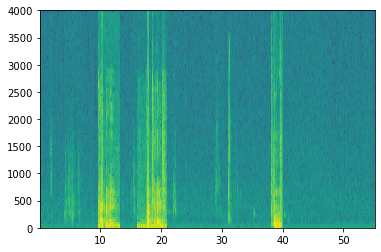

In [13]:
x, y = create_training_example(backgrounds[0], activates, negatives)

In [14]:
IPython.display.Audio("./twd_audio_examples/train.wav")

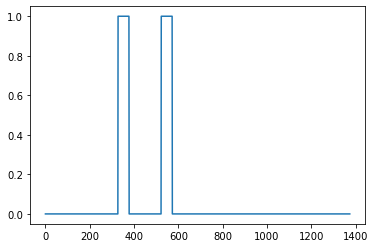

In [15]:
plt.plot(y[0])

# Trigger Word Detection Model
## Full Data
- training set
    * use the above process to generate 26 examples
- dev set
    * 25 examples, follow the princple that "the dev set should be similar to the test set distribution"
    * created a dev set using the same distribution as the real inputs: 10-second audio clips of people saying "activate" and other random words, labeled by hand

In [16]:
# load preprocessed training set
X_train = np.load('./twd_train_dev_data/X_train.npy')
y_train = np.load('./twd_train_dev_data/y_train.npy')

# load preprocessed dev set
X_dev = np.load('./twd_train_dev_data/X_dev.npy')
y_dev = np.load('./twd_train_dev_data/y_dev.npy')

## Architecture
The goal is to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. The network will use 4 layers:
- one convoluntional layer
- two GRU layers
- one dense layer

**1D convolutional layer step**
- input: 5511 time-step spectrogram, each time-step is a vector of 101 units
- output: 1375 time-step vector
    * this output is further processed by multiple layers to get the final $T_y = 1375$ time-step output
- work as extracting low-level features and then possibly generating an output of a smaller dimension
- computationally, the 1D conv layer helps speed up the model because now the GRU can process only 1375 time-steps rather than 5511 time-steps

**Further step: GRUs and dense with sigmoid**
- two GRU layers read the sequence of inputs from left to right
- the dense layer plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$
    * here we use `TimeDistributed` layer to build dense layer: the parameters used for the dense layer are the same for every time step
    * because y is a binary value (0 or 1), here we use a sigmoid activation function in the output

**Unidirectional RNN**
- note that we use a **unidirectional RNN** rather than a bidirectional RNN
    * this is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said
    * if using bidirectional RNN, we would have to wait for the whole 10 seconds of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip

In [17]:
def model(input_shape):
    
    # Input layer
    X_input = tf.keras.layers.Input(shape=input_shape)
    
    # Conv layer: 196 filters, 15 kernel size, 4 strides
    X = tf.keras.layers.Conv1D(filters=196, kernel_size=15, strides=4)(X_input)  ## Conv1D
    X = tf.keras.layers.BatchNormalization()(X)                                  ## Batch normalization
    X = tf.keras.layers.Activation('relu')(X)                                    ## ReLU activation
    X = tf.keras.layers.Dropout(rate=0.2)(X)                                     ## Dropout
    
    # 1st GRU layer: 128 units, return the sequences
    X = tf.keras.layers.GRU(units=128, return_sequences=True)(X)                 ## GRU
    X = tf.keras.layers.Dropout(rate=0.2)(X)                                     ## Dropout
    X = tf.keras.layers.BatchNormalization()(X)                                  ## Batch normalization
    
    # 2nd GRU layer: 128 units, return the sequences
    X = tf.keras.layers.GRU(units=128, return_sequences=True)(X)                 ## GRU
    X = tf.keras.layers.Dropout(rate=0.2)(X)                                     ## Dropout
    X = tf.keras.layers.BatchNormalization()(X)                                  ## Batch normalization
    X = tf.keras.layers.Dropout(rate=0.2)(X)                                     ## Dropout
    
    # Time-distributed dense layer: 1 unit, sigmoid activation
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1, activation='sigmoid'))(X)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=X)
    
    return model

## Experiment

In [18]:
model = model((Tx, n_freq))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization (BatchNo (None, 1375, 196)         784       
_________________________________________________________________
activation (Activation)      (None, 1375, 196)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1375, 196)         0         
_________________________________________________________________
gru (GRU)                    (None, 1375, 128)         125184    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 128)         0     

- Train

In [19]:
# load pre-trained model to save time: already trained for 3 hours on a GPU + 4000 training examples
model = tf.keras.models.load_model('./twd_model.h5')

# adjust the dropout rate since in tf2, it is dropout rate instead of keep rate
for l in [4, 6, 9, 11]:
    model.layers[l].rate = 0.2

In [20]:
# further training
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=5, epochs=1)

Train on 26 samples
26/26 [==============================] - 14s 535ms/sample - loss: 1.1917 - accuracy: 0.8102


- Evaluation

In [21]:
loss, acc = model.evaluate(X_dev, y_dev)
print('Dev set accuracy =', acc)

25/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 34ms/sample - loss: 0.3236 - accuracy: 0.9501
Dev set accuracy = 0.95008


## Make Prediction
1. use the model to predict the probabilities for the input audio
2. with the pribability of having detected "activate" word at each output time-step, insert a "chiming" sound to play when the probability is above a certain threshold
    * there are several 1's after "activate" but we want to chime only once
    * insert a chime sound at most once every 75 output time-steps to avoid inserting two chimes for a single "activate"
    * similar to non-max suppression from computer vision

In [22]:
def detect_triggerword(filename):
    '''
    Plot the spectrogram & predicted probability; Return the predictions
    '''
    
    plt.subplot(2, 1, 1)
    x = graph_spectrogram(filename)  # spectrogram output: (n_freq, Tx)
    x = x.swapaxes(0, 1)             # swap the axis to what we want: (Tx, n_freq)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0, :, 0])
    plt.ylabel('Probability')
    plt.show()
    
    return predictions

In [23]:
def insert_chime_activate(filename, predictions, threshold):
    '''
    Insert one chime sound after the "activate" if the predicted probability is above the threshold
    '''
    
    audio = AudioSegment.from_wav(filename)  # pre-loaded
    chime = AudioSegment.from_wav('./twd_audio_examples/chime.wav')
    Ty = predictions.shape[1]
    
    # Initialize the number of consecutive output time-steps to 0
    consecutives = 0
    
    # Loop over the output time-steps in the y
    for i in range(Ty):
        
        ## increment consecutive output time-steps
        consecutives += 1
        
        ## if prediction is higher than the threshold and more than 75 consecutive output time-steps have passed
        if predictions[0, i, 0] > threshold and consecutives > 75:
            ## insert chime into the audio
            audio = audio.overlay(chime, position=((i / Ty) * audio.duration_seconds) * 1000)
            ## reset consecutive output time-steps to 0
            consecutives = 0
    
    audio.export('./twd_prediction/chime_output.wav', format='wav')

- Test

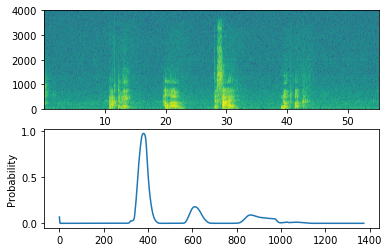

In [24]:
filename = './twd_raw_data/dev/1.wav'

predictions = detect_triggerword(filename)

insert_chime_activate(filename, predictions, 0.5)

IPython.display.Audio('./twd_prediction/chime_output.wav')

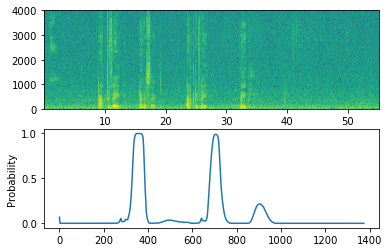

In [25]:
filename = './twd_raw_data/dev/2.wav'

predictions = detect_triggerword(filename)

insert_chime_activate(filename, predictions, 0.5)

IPython.display.Audio('./twd_prediction/chime_output.wav')